# Import Necessary Libraries

In [14]:
import json
import re
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import inflection as inf
import geopandas
from datetime import timedelta, datetime, timezone
from datetime import datetime as dt
from collections import Counter
from nltk.corpus import stopwords
from scipy.signal import argrelextrema
from shapely.geometry import Point, Polygon
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import AnchoredText
pd.options.mode.chained_assignment = None

## ImageMagick
To run the .gif maker in the topic geotracker, the user needs to install ImageMagick.  The Windows binary can be fouond here : https://imagemagick.org/download/binaries/ImageMagick-7.0.10-37-Q16-HDRI-x64-dll.exe

# Load Corpus Data

In [15]:
with open(os.path.join("data", "docs.json")) as json_file:
    data = json.load(json_file)
df = pd.json_normalize(data)
df.head()

,event_id,content,title,date,sources,people,organizations,locations,id,summary
0,4a68a737-a357-47ea-a4b9-afe4f3c1f460,"FLAGSTAFF, Ariz. -- An excavator used to clea...",Spark from wildfire-prevention efforts likely ...,2019-09-13T18:17:35Z,[ABC7NY],"[8e7aff20-4281-5023-8407-f43e5ba289e4, 4fc245e...",[9d4d391e-a27d-4b76-a783-7ce20c9160a0],"[28152159-6443-50c6-864c-f6e9920c9232, 15f3e2e...",7ac25cda-aec2-5af1-a937-4fee15ea35ba,The excavator was working on steep slopes near...
1,3b4e3874-2034-4cc7-9929-09d60f1092e7,“Wildfire raging through the Paradise region i...,Conditions of the California wildfire reflect ...,2018-11-16T12:53:23Z,[ShowMe Plettenberg Bay],"[0aa3184c-c835-5afa-a5e7-656c37a08a7b, 193958f...",[153dc210-6604-4db6-b374-d9167690f2cf],"[dfbf9ad3-9e72-5ba9-99ac-fd32ca480ac1, 2ac73e0...",b04dba07-ffc0-5a49-be3b-6eaaf57150e2,"""Wildfire raging through the Paradise region i..."
2,d3c463cc-0b2f-4e51-9f99-f2f6cfc90d0f,Montanans were fortunate this year’s wildfire ...,"Hazardous homes increasing wildfire risks, costs",2018-09-27T19:14:34Z,[Bozeman Daily Chronicle],[a9637d0a-7c6a-5eeb-8f5c-947d3fea81bd],[81029b9e-056b-4213-8595-f53c7555d4ae],"[1709e49c-551f-5a2d-87a2-d84942ac24a0, 7534d4a...",71e746b0-9de5-5602-a7ca-deceb760ab83,"In Gallatin County there are 3,848 homes in ar..."
3,0d357eaa-cf9c-406b-a551-503832c6dd5b,1 Introduction \nLarge wildfires are increasi...,"Resilience to Large, “Catastrophic” Wildfires ...",2020-07-09T12:13:46Z,[Earth's Future],"[6eac2fd9-b19b-5a66-b2a0-cfba00919fc9, 8cdbbf2...","[5eb2f096-ed8a-4aa9-9f8d-e2bdb45cd7da, 6a97278...","[7b656f8b-97f4-5ca3-b533-2d9030312b44, 04557f0...",4d73f52b-d24d-5314-952e-5d42272c470b,"First, we expect that vegetation functional gr..."
4,f0365861-6f2f-42bc-a0ef-35d2c5e52d00,Discussing wildfire protection and management ...,"Rod Rose, Bushfire Management Expert",2020-04-28T16:01:45Z,[CSR Wire],[d18aeb90-b77f-5f80-aaa9-98058b97d922],"[8f808d10-96da-41fa-a477-62802c44b98f, fb58c4b...","[4fbe630c-4a31-5847-a4c0-333ad0fb9072, 7b656f8...",05c861d4-887a-544e-a309-ae9fe36e4366,Rod won the Fire Protection Association of Aus...


# Data Manipulation
## Date
In order to enable time series creation, sorting and extraction of specific time windows, the date column will be converted to a native python datetime data structure.

In [16]:
df["date"] = pd.to_datetime(df["date"])
df.sort_values("date", inplace=True)

## Data Imputation
To facilitate the searching of the corpus, missing values for the document content, title and summary will be imputed as empty strings.

In [17]:
for column in ["content", "title", "summary"]:
    df[column].fillna("", inplace=True)

# Time Series Creation

## Limit the Corpus to Single Topic

In [18]:
def find_event(df, topic):
    """ 
    Function to subset a corpus DataFrame to entries that contain the topic word.
    :param df: pandas.DataFrame representing the document corpus.
    :param topic: str representing the word to search for in the title, summary and content.
    :returns: pandas.DataFrame of documents containing the requested topic.
    """
    return df[(df['content'].str.contains(topic)) |
              (df['summary'].str.contains(topic)) |
              (df['title'].str.contains(topic))]


topic = "wildfire"
topic_df = find_event(df, topic)
topic_df.head()

,event_id,content,title,date,sources,people,organizations,locations,id,summary
8718,a8e3d54f-6a69-4abb-a948-26a482b7a845,CLOSED – #BCHwy97 in both direction 1 km north...,Update: Highway 97 closed as crews fight wildf...,2018-09-01 01:27:58+00:00,"[Revelstoke Times Review, Revelstoke Times Rev...",[6002fee2-1381-560c-a955-0c5691680639],"[5074dfec-cba3-495d-8793-02bf28ce1395, 7ce95b9...",[],83f536e8-fa10-5d49-ad50-2ad456f5cbf0,Update 6:25 p.m. Highway 97 near Okanagan Fal...
4148,be82e7a8-9b0b-43cf-8943-44de914ae4b1,Photo courtesy of Kari Greer with the U.S. For...,Forest funds spread thin by wildfire,2018-09-01 02:24:51+00:00,"[East Oregonian, East Oregonian (Pendleton, Or...","[d5803454-f243-550b-9cac-236270665507, a794f34...","[a45a6611-34fd-4318-8cf9-8f7bac4ab764, dd06d8f...","[7534d4a2-f1cc-51de-a5cd-7b5523fc9ec1, 6705285...",70b5c618-49c4-5145-8cce-6457eca87d67,Giles said the number of fires his team is cal...
3329,59fcece2-2901-4fef-aa9d-69a40d6c50b5,Don’t Let Normal Temperatures Fool You - Wildf...,Labor Day Weekend Brings Continual Fire Concerns,2018-09-01 03:00:19+00:00,[Calaveras Enterprise],"[a870f9a3-85ef-572c-9c5d-c69008403319, 2df053c...",[6ad9a6e1-8f2e-4405-af5d-65d183ca3dbf],"[04557f0b-9d0b-5ee4-b5d5-0422f3e5e233, 2ac73e0...",90471ba7-2ab0-5bc1-82be-989caec30b53,"""This year we have seen not only the largest w..."
2464,6a17783f-3088-4575-97c5-b47faa22317f,"For Steven Kozuki, the executive director of t...",Balance: Key to success in forest industry,2018-09-01 03:01:26+00:00,[Williams Lake Tribune],"[c6d99b21-6d2b-5d94-8b39-e0cd5e08ae4e, 6143a7d...","[41dccb7d-4ae1-4aad-8ecc-0757f3a7e219, 355e089...","[126d2560-d670-5c09-b076-fbec842decf6, 02422dc...",bee15480-1b53-5d1b-89fc-94031c53b170,Kozuki was in Williams Lake on Aug. 24 for the...
6142,a8e3d54f-6a69-4abb-a948-26a482b7a845,B.C. Wildfire crews are responding to a new wi...,UPDATE: Wildfire burning west of Okanagan Fall...,2018-09-01 04:31:30+00:00,[InfoNews.ca],[60f38efe-beab-58c9-ae03-b6a4e9bad375],[058929cd-f7dd-41a7-9052-9dfad8c04947],[],bf602e56-df4f-5e5a-8214-edc31be69d50,Wildfire crews are responding to a new wildfi...


## Build Daily Count of Topic Documents

In [19]:
# Create dataframe of just the document date.
vols = topic_df[["date"]].copy()
vols.sort_values("date", inplace=True)

# Aggregate document count by year/month/day
vols_counts = vols.groupby(
    [vols["date"].dt.year, vols["date"].dt.month, vols["date"].dt.day]).count()
vols_counts.columns = ["count"]
vols_counts.index.names = ["years", "months", "days"]

# Extract volume counts and dates as arrays
counts = vols_counts["count"].to_numpy()
dates = vols_counts.index

## Smooth Daily Count to Identify Peaks
A single windowed average was initially used to reduce the number of peaks in the volume count figure.  The single windowed average proved to have too many peaks to be useful, so a second windowed average was applied to the first.

In [20]:
def windowed_average(arr, trail_entries, lead_entries):
    """
    Function that does a sliding window average over an array of numerics.
    :param arr: numpy.ndarray of numeric values to do sliding average over.
    :param trail_entries: int representing the trailing number of entries to
        include in window
    :param lead_entries: int representing the leading number of entries to 
        include in window
    :returns: numpy.ndarray of the windowed average of the given array
    """
    windowed_avg = []
    for idx in range(len(arr)):
        start_idx = 0 if idx - trail_entries < 0 else idx - trail_entries
        end_idx = len(arr) - 1 if idx + \
            lead_entries >= len(arr) else idx + lead_entries
        window = arr[start_idx:end_idx+1]
        avg = sum(window)/len(window)
        windowed_avg.append(avg)

    return np.array(windowed_avg)


# TODO: Port tests to python unittest in production
# Unit Test #1
test_arr = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
test_res = windowed_average(test_arr, trail_entries=0, lead_entries=0)
assert np.array_equal(
    test_arr, test_res), "windowed_average(): smoke test failed"

# Unit Test #1
test_arr = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
test_res = windowed_average(test_arr, trail_entries=1, lead_entries=0)
test_ans = np.array([0.0, .5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
assert np.array_equal(
    test_ans, test_res), "windowed_average(): trail_entries test failed"

# Unit Test #3
test_arr = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
test_res = windowed_average(test_arr, trail_entries=1, lead_entries=1)
test_ans = np.array([.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9.5])
assert np.array_equal(
    test_ans, test_res), "windowed_average(): lead_entries test failed"

In [21]:
trailing_days = 14
leading_days = 14

windowed_avg = windowed_average(counts, trailing_days, leading_days)
double_windowed_avg = windowed_average(
    windowed_avg, trailing_days, leading_days)

ind_max = argrelextrema(double_windowed_avg, np.greater)
maxvals = double_windowed_avg[ind_max]

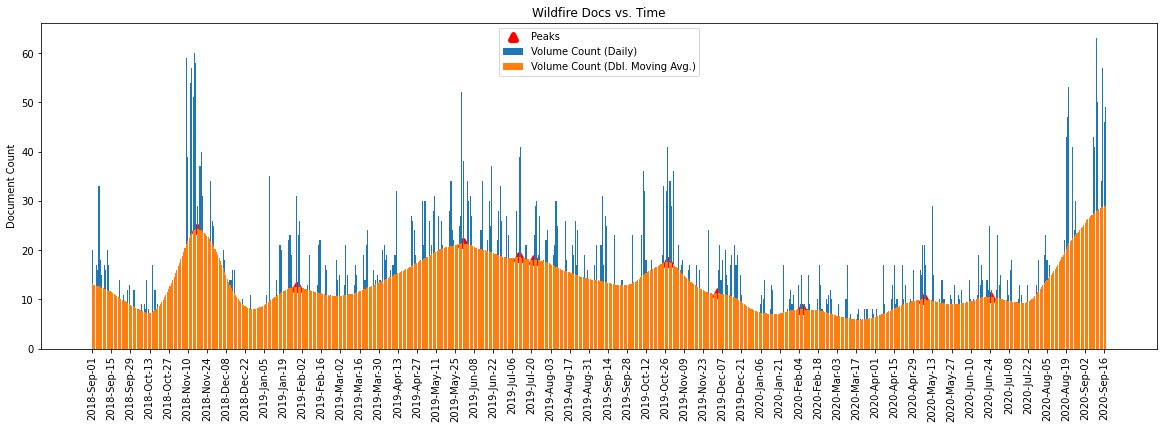

In [22]:
# Graph volume counts over time
plt.figure(figsize=(20, 6))
plt.title("%s Docs vs. Time" % topic.title())
plt.ylabel("Document Count")
date_labels = [datetime.strptime(x, "%Y:%m:%d").strftime(
    "%Y-%b-%d") for x in ["%d:%d:%d" % tup for tup in vols_counts.index]]
plt.bar([x for x in range(len(vols_counts.index))], vols_counts["count"],
        tick_label=date_labels, label="Volume Count (Daily)")
# plt.bar([x for x in range(len(vols_counts.index))], np.array(windowed_avg), label="Volume Count (Moving Avg.)")
plt.bar([x for x in range(len(vols_counts.index))], np.array(
    double_windowed_avg), label="Volume Count (Dbl. Moving Avg.)")
plt.scatter(ind_max, maxvals, c="r", marker="^", linewidths=5, label="Peaks")

# Only display a date tick label every two weeks
label_frequency = 14
xticks = plt.gca().xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % label_frequency != 0:
        xticks[i].set_visible(False)
plt.xticks(rotation=(90))
plt.legend()
plt.show()

The graph above reflects a time series of document volume count for the topic "wildfire".  All documents that contained the the topic in the title, summary or content are represented in the series.  A double moving average (in orange) was used to smooth out and identify approximate locations for the peaks of the daily document count (in blue).  

# Event Overviews
## Build Event Windows Around Peaks

In [23]:
trailing_time = timedelta(weeks=2)
leading_time = timedelta(weeks=1)

event_windows = []
for date_tup in dates[ind_max[0]]:
    peak_date = datetime(
        year=date_tup[0], month=date_tup[1], day=date_tup[2], tzinfo=timezone.utc)
    window_start_date = peak_date - trailing_time
    window_end_date = peak_date + leading_time
    event_windows.append((window_start_date, window_end_date, peak_date))
    print("Event Window: %s - %s" % (window_start_date.strftime("%m/%d/%Y"),
                                     window_end_date.strftime("%m/%d/%Y")))

Event Window: 11/03/2018 - 11/24/2018
Event Window: 01/15/2019 - 02/05/2019
Event Window: 05/17/2019 - 06/07/2019
Event Window: 06/27/2019 - 07/18/2019
Event Window: 07/08/2019 - 07/29/2019
Event Window: 10/14/2019 - 11/04/2019
Event Window: 11/20/2019 - 12/11/2019
Event Window: 01/23/2020 - 02/13/2020
Event Window: 04/23/2020 - 05/14/2020
Event Window: 06/10/2020 - 07/01/2020


## Analyze Titles of Documents
The strategy for creating an overview will involve extracting the most common words from all the document titles from each event period and picking stories that use those words.

In [24]:
def normalize_str(raw_str):
    """
    Function that takes a raw string representing a document title, summary or content,
    removes the punctuation, symbols, escape characters etc and breaks it down to a 
    list of lower case, singular case words.
    :param raw_str: str parsed from a document or json
    :returns: list of str with lower case, singular versions of the words found in 
        the raw_str
    """

    # Build set of common english stopwords
    ss = set(stopwords.words('english'))
    ss.add("the")  # Why this isn't in there mystifies me

    # Keep only letters, numbers and the space.
    keywords_only_alphanum = re.sub(r'[^a-zA-Z0-9 ]', '', raw_str)

    # Lowercase and depluralize
    # TODO: figure out a better solution for California signularizing to 'californium'
    keywords_lowercase = [x.lower() for x in keywords_only_alphanum.split()]
    keywords_singular = [inf.singularize(x) for x in keywords_lowercase if x not in [
        "california", "alberta"]]
    
    # TODO: Consider proper lemmatization and stemming

    # Remove common English stopwords
    keywords_no_stopwords = [x for x in keywords_singular if x not in ss]

    return keywords_no_stopwords

# Unit Test
# Should exclude watchwords: is, a, only, I, through, my, me, the
# Check singularization with chains
test_str = "Peace is a lie. \
            There is only Passion. \
            Through Passion I gain Strength. \
            Through Strength I gain Power. \
            Through Power I gain Victory. \
            Through Victory my chains are Broken. \
            The Force shall free me."
test_res = normalize_str(test_str)
assert len(test_res) == 18
assert "chains" not in test_res and "chain" in test_res

In [25]:
def extract_keywords(series_of_words, appearance_threshold=3):
    """
    Function that creates a basic bag of words based on a Pandas Series of strings.  Can
    filter words with multiplicity less than or equal to a threshold.
    :param series_of_words: pandas.Series representing a corpus of documents.
    :param appearance_threshold: int, the multiplicity at or below which a word is excluded
        from the counting.
    :raises ValueError: if appearance_threshold <= 0
    :raises TypeError: if appearance_threshold is not integer
    :returns collections.Counter of the words whose count exceeds appearance_threshold
    """
    if not isinstance(appearance_threshold, int):
        raise TypeError("extract_keywords(): threshold for word multiplicity must be given as integer, received %s" %
                        str(type(appearance_threshold)))
    if appearance_threshold <= 0:
        raise ValueError(
            "extract_keywords(): threshold for word multiplicity must be greater than 0.")

    # Build set of common english stopwords
    ss = set(stopwords.words('english'))
    ss.add("the")  # Why this isn't in there mystifies me

    keywords = " ".join(series_of_words)
    keywords_no_stopwords = normalize_str(keywords)

    # Count words, bag of words style
    keywords_counter = Counter(keywords_no_stopwords)
    keywords_important = Counter(
        {k: v for k, v in keywords_counter.items() if v > appearance_threshold})

    return keywords_important


# Unit Test #1
# 'all' is a stopword and shouldn't appear in the results
test_series = pd.Series(
    ["all", "all boys", "all boys cook", "all boys cook dinner"])
test_res = extract_keywords(test_series, appearance_threshold=1)
assert test_res.keys() == {"boy", "cook"}
assert test_res["boy"] == 3
assert test_res["cook"] == 2

# Unit Test #2
# Test of the appearance threshold
test_series = pd.Series(
    ["all", "all boys", "all boys cook", "all boys cook dinner"])
test_res = extract_keywords(test_series, appearance_threshold=2)
assert test_res.keys() == {"boy"}
assert test_res["boy"] == 3

# Unit Test #3
# Test of the depluralizer
test_series = pd.Series(
    ["boy", "all boys", "all boys cook", "all boys cook boys"])
test_res = extract_keywords(test_series, appearance_threshold=2)
assert test_res.keys() == {"boy"}
assert test_res["boy"] == 5

# Unit Test #4
# Test the ducktyping of the input data
test_series = ["boy", "all boys", "all boys cook", "all boys cook boys"]
test_res = extract_keywords(test_series, appearance_threshold=2)
assert test_res.keys() == {"boy"}
assert test_res["boy"] == 5

# # TODO: Port test code into python unittest framework during production
# # Unit Test #5
# # Test the exceptions
# test_series = ["boy", "all boys", "all boys cook", "all boys cook boys"]
# test_res = extract_keywords(test_series, appearance_threshold = 1.2)
# test_res = extract_keywords(test_series, appearance_threshold = -1)

In [26]:
# Restrict the number of stories/categories per event period to this number
top_stories_per_period = 5
title_max_char = 100

for event_window in event_windows:

    # Format the event header
    event = df[(df["date"] > event_window[0]) & (df["date"] < event_window[1])]
    
    # Analyze titles
    title_words = extract_keywords(event["title"])
    most_common_words = [x[0]
                         for x in title_words.most_common()[:top_stories_per_period]]
    

    start_date = event["date"].iloc[0].strftime("%m/%d/%Y")
    end_date = event["date"].iloc[-1].strftime("%m/%d/%Y")
    peak_date = event_window[2].strftime("%m/%d/%Y")
    print()
    print("Peak Date: %s" % str(peak_date))
    print("Event Window: %s - %s" % (start_date, end_date))
    print("Top %d topics: %s" %
          (top_stories_per_period,  ", ".join(most_common_words)))

    # Treat the top most-common words as categories within an event period
    top_stories = []
    for mcw_idx, most_common_word in enumerate(most_common_words):

        # Build a sub-DataFrame of the 'most_common_word' category
        word_df = find_event(event, most_common_word)

        # Complicated way to increase chances of getting a story that doesn't
        # relate to a previous category
        # TODO: Update this with a cosine similarity approach and treat more similar
        # to gramm-schmidt orthogonalization
        if mcw_idx > 0:
            used_words = most_common_words[0:mcw_idx]
            new_used_words = used_words[:]
            for used_word in used_words:
                new_used_words.append(used_word)
                new_used_words.append(used_word.title())
                new_used_words.append(used_word.lower())
                new_used_words.append("%ss" % used_word)
                new_used_words.append("%ss" % used_word.title())
            new_used_words = list(set(new_used_words))
            word_df = word_df[~word_df["title"].str.contains(
                "|".join(new_used_words))]

        # Build a count of how many times the category word appears in the category
        # content as a proxy for relevance
        word_df["relevance"] = word_df["content"].apply(
            lambda x: sum([y in most_common_word for y in x.split(" ")]))
        word_df = word_df.sort_values("relevance")
        try:
            top_story_title = word_df.iloc[-1]["title"]
            top_stories.append(top_story_title)
        except:
            pass

    top_stories = list(set(top_stories))
    for top_story in top_stories:
        print("\t%s..." % top_story[0:title_max_char])

NameError: name 'event' is not defined

Above is a report of the top stories discerned from around the peaks of wildfire activity.  Unsurprisingly, wildfires tend to dominate the top stories.  An attempt was made to try and remove commonality between the top-five stories, but usually with little success.

# Topic Geotracker
Our attempt at a new feature will be a display of the locations of events related to a single topic.  We'll set out to take a sub-corpus related to a certain topic and show the progression through time, on a map, of where they play out. 

## Load Location Data

In [ ]:
with open(os.path.join("data", 'entities_meta.json')) as json_file:
    entities_data = json.load(json_file)

In [ ]:
locs_df = pd.json_normalize(entities_data["locations"])
locs_df = locs_df.dropna()
locs_df.head()

## Merge Location Data into Document DataFrame

In [ ]:
def id_to_ll(list_of_ids):
    """
    Function to convert a list of location IDs into shapely Points for plotting.
    :param list_of_ids: list of str, where each str represents an ID of a location in the
        corpus
    :returns: list of shapely.Point
    """
    lls = []
    for idnt in list_of_ids:
        location = locs_df[locs_df["id"] == idnt]
        try:
            lls.append(
                Point(location["longitude"].iloc[0], location["latitude"].iloc[0]))
        except:
            pass
    return lls


locs = topic_df["locations"].apply(id_to_ll)

In [ ]:
dates = topic_df["date"]
states = geopandas.read_file(os.path.join("data", 'usa-states-census-2014.shp'))

## Build Animation of Topical Events

In [ ]:
fig, ax = plt.subplots()
fig.set_tight_layout(True)
ax.set_title("Wildfire Events in Western USA")

# TODO: Be real, analyze the sub-corpus and set the limits based on the min/max of the locations.
ax.set_xlim([-130, -100])
ax.set_ylim([30, 50])
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
states.plot(ax=ax)


def update(i):
    xs = [p.x for p in locs[i]]
    ys = [p.y for p in locs[i]]
    ax.scatter(xs, ys, c="r", marker="X")
    anchored_text = AnchoredText(str(dates.iloc[i]), loc=2)
    ax.add_artist(anchored_text)
    return ax

#TODO: This method is super slow and terrible.  Ultimately this would be replaced in production
# by something color like some javascript stuff.
anim = FuncAnimation(fig, update, frames=np.arange(0, 10), interval=200)

anim.save(os.path.join("outputs", 'wildfires_persistent_example.gif'), dpi=80, writer='imagemagick')

The topic "wildfire" was present in many documents contained in the corpus.  The animation generated here represents the occurrence and geolocation of the event as time unfolds.  The time of the events appears in the upper left corner of the animation.  

![SegmentLocal](data/wildfires_persistent.gif "segment")